In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, precision_score, 
                            recall_score, classification_report, confusion_matrix,
                            roc_curve, precision_recall_curve)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Hyperparameter Optimization
import optuna
from optuna.samplers import TPESampler

# Utilities
import joblib
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully")

All libraries imported successfully


In [2]:
# Configuration and Settings
class Config:
    # Paths
    DATA_DIR = "data"
    MODELS_DIR = "models"
    REPORTS_DIR = "reports"
    FIGS_DIR = "figures"
    
    # Random seed for reproducibility
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)
    
    # Data settings
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    
    # Model settings
    CV_FOLDS = 5
    N_TRIALS = 50
    N_JOBS = -1
    
    # Create directories
    for dir_path in [DATA_DIR, MODELS_DIR, REPORTS_DIR, FIGS_DIR]:
        os.makedirs(dir_path, exist_ok=True)

config = Config()
print(f"Configuration initialized")
print(f"Models will be saved to: {config.MODELS_DIR}")

Configuration initialized
Models will be saved to: models


In [3]:
# Create Dataset with Specified Columns Only
def create_dataset_with_specified_columns(n_samples=20000):
    """
    Create dataset using only the columns specified in the image
    """
    np.random.seed(config.RANDOM_STATE)
    
    # Applicant Fields
    customer_id = [f'CUST{str(i).zfill(6)}' for i in range(1, n_samples + 1)]
    
    # Age with realistic distribution
    age = np.random.normal(42, 12, n_samples).astype(int)
    age = np.clip(age, 18, 80)
    
    # Employment status
    employment_status = np.random.choice(
        ['Employed', 'Self-Employed', 'Unemployed', 'Retired', 'Student'],
        n_samples,
        p=[0.58, 0.15, 0.08, 0.12, 0.07]
    )
    
    # Education level
    education_level = np.random.choice(
        ['High School', 'Diploma', 'Bachelor', 'Master', 'PhD'],
        n_samples,
        p=[0.20, 0.25, 0.35, 0.15, 0.05]
    )
    
    # Financial Fields
    annual_income = np.random.lognormal(mean=10.8, sigma=0.5, size=n_samples).astype(int)
    annual_income = np.clip(annual_income, 20000, 300000)
    
    num_previous_loans = np.random.negative_binomial(n=2, p=0.4, size=n_samples)
    num_previous_loans = np.clip(num_previous_loans, 0, 15)
    
    avg_payment_delay_days = np.random.exponential(scale=8, size=n_samples).astype(int)
    avg_payment_delay_days = np.clip(avg_payment_delay_days, 0, 90)
    
    # Credit History
    credit_history_length = np.random.gamma(shape=3, scale=2, size=n_samples).astype(int)
    credit_history_length = np.clip(credit_history_length, 1, 30)
    
    num_defaults_base = np.random.poisson(lam=0.4, size=n_samples)
    num_defaults = np.where(employment_status == 'Unemployed', 
                           num_defaults_base + np.random.poisson(0.3, n_samples),
                           num_defaults_base)
    num_defaults = np.clip(num_defaults, 0, 4)
    
    # Current credit score (strongly correlated with history and defaults)
    base_score = 600 + 10 * credit_history_length - 40 * num_defaults
    current_credit_score = np.random.normal(base_score, 35).astype(int)
    current_credit_score = np.clip(current_credit_score, 350, 850)
    
    # Loan Parameters
    loan_amount = np.random.lognormal(mean=10.2, sigma=0.7, size=n_samples).astype(int)
    loan_amount = np.clip(loan_amount, 1000, 150000)
    
    loan_term_months = np.random.choice([12, 24, 36, 48, 60, 72], n_samples, 
                                       p=[0.10, 0.15, 0.30, 0.20, 0.15, 0.10])
    
    loan_purpose = np.random.choice(
        ['Business', 'Crypto-Backed', 'Car Loan', 'Education', 'Home Loan'],
        n_samples,
        p=[0.25, 0.15, 0.30, 0.15, 0.15]
    )
    
    # Collateral
    collateral_present = np.random.choice(['Yes', 'No'], n_samples, p=[0.45, 0.55])
    
    # Create dataframe with exactly the columns from the image
    df = pd.DataFrame({
        'customer_id': customer_id,
        'age': age,
        'employment_status': employment_status,
        'education_level': education_level,
        'annual_income': annual_income,
        'num_previous_loans': num_previous_loans,
        'avg_payment_delay_days': avg_payment_delay_days,
        'credit_history_length': credit_history_length,
        'num_defaults': num_defaults,
        'current_credit_score': current_credit_score,
        'loan_amount': loan_amount,
        'loan_term_months': loan_term_months,
        'loan_purpose': loan_purpose,
        'collateral_present': collateral_present
    })
    
    # Generate target with complex interactions
    risk_score = np.zeros(n_samples)
    
    # Key risk factors
    risk_score += (df['current_credit_score'] < 620).astype(int) * 0.30
    risk_score += (df['num_defaults'] > 0).astype(int) * 0.25
    risk_score += (df['employment_status'] == 'Unemployed').astype(int) * 0.20
    risk_score += (df['avg_payment_delay_days'] > 30).astype(int) * 0.15
    risk_score += (df['collateral_present'] == 'No').astype(int) * 0.10
    risk_score += (df['loan_amount'] / df['annual_income'] > 0.5).astype(int) * 0.15
    risk_score += (df['credit_history_length'] < 2).astype(int) * 0.10
    
    # Interactions
    risk_score += ((df['current_credit_score'] < 650) & (df['num_defaults'] > 0)).astype(int) * 0.15
    risk_score += ((df['employment_status'] == 'Self-Employed') & (df['avg_payment_delay_days'] > 15)).astype(int) * 0.10
    
    # Add noise
    noise = np.random.normal(0, 0.1, n_samples)
    final_risk = np.clip(risk_score + noise, 0.05, 0.95)
    
    # Generate binary target
    df['default_flag'] = (np.random.random(n_samples) < final_risk).astype(int)
    
    print(f"Dataset created with specified columns only")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Default rate: {df['default_flag'].mean():.2%}")
    
    return df

# Create dataset
sample_path = os.path.join(config.DATA_DIR, "credit_dataset.csv")
if not os.path.exists(sample_path):
    df = create_dataset_with_specified_columns(n_samples=25000)
    df.to_csv(sample_path, index=False)
    print(f"\nDataset saved to {sample_path}")
else:
    df = pd.read_csv(sample_path)
    print(f"Loaded existing dataset from {sample_path}")
    print(f"Shape: {df.shape}")
    print(f"Default rate: {df['default_flag'].mean():.2%}")

Dataset created with specified columns only
Shape: (25000, 15)
Columns: ['customer_id', 'age', 'employment_status', 'education_level', 'annual_income', 'num_previous_loans', 'avg_payment_delay_days', 'credit_history_length', 'num_defaults', 'current_credit_score', 'loan_amount', 'loan_term_months', 'loan_purpose', 'collateral_present', 'default_flag']
Default rate: 41.43%

Dataset saved to data/credit_dataset.csv


In [4]:
# Preprocessing and Feature Engineering (Using Only Specified Columns)
def preprocess_specified_columns(df):
    """
    Preprocess and engineer features using only the columns from the image
    """
    df = df.copy()
    
    # Drop customer_id as it's not useful for modeling
    if 'customer_id' in df.columns:
        df = df.drop('customer_id', axis=1)
    
    # 1. Handle missing values (if any)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    
    # 2. Create interaction features from existing columns only
    # Financial ratios
    df['income_to_loan_ratio'] = df['annual_income'] / (df['loan_amount'] + 1)
    df['payment_per_month'] = df['loan_amount'] / df['loan_term_months']
    df['payment_to_income'] = df['payment_per_month'] / (df['annual_income'] / 12)
    
    # Risk indicators
    df['default_rate'] = df['num_defaults'] / (df['num_previous_loans'] + 1)
    df['credit_utilization'] = (df['num_previous_loans'] * df['loan_amount']) / (df['annual_income'] + 1)
    df['payment_reliability'] = 1 / (df['avg_payment_delay_days'] + 1)
    
    # Interaction features
    df['credit_history_x_score'] = df['credit_history_length'] * df['current_credit_score']
    df['default_x_delay'] = df['num_defaults'] * df['avg_payment_delay_days']
    df['age_x_income'] = df['age'] * df['annual_income'] / 100000
    
    # Binned features
    df['credit_score_category'] = pd.cut(df['current_credit_score'], 
                                         bins=[0, 580, 670, 740, 800, 850],
                                         labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
    
    df['age_group'] = pd.cut(df['age'],
                             bins=[0, 25, 35, 50, 65, 100],
                             labels=['Young', 'Early Career', 'Mid Career', 'Pre-retirement', 'Retirement'])
    
    df['dti_category'] = pd.cut(df['loan_amount'] / df['annual_income'] * 100,
                                bins=[0, 20, 36, 43, 50, 200],
                                labels=['Low', 'Moderate', 'High', 'Very High', 'Severe'])
    
    # Polynomial features for important columns
    important_numerics = ['current_credit_score', 'annual_income', 'credit_history_length', 'age']
    for col in important_numerics:
        df[f'{col}_squared'] = df[col] ** 2
        df[f'{col}_log'] = np.log1p(df[col])
    
    # 3. Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns and col != 'default_flag':
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    # One-hot encode important categoricals
    important_cats = ['employment_status', 'education_level', 'loan_purpose', 
                     'collateral_present', 'credit_score_category', 'age_group', 'dti_category']
    
    for col in important_cats:
        if col in df.columns:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
    
    # 4. Handle outliers
    for col in df.select_dtypes(include=[np.number]).columns:
        if col != 'default_flag':
            q1 = df[col].quantile(0.01)
            q3 = df[col].quantile(0.99)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            df[col] = df[col].clip(lower_bound, upper_bound)
    
    print(f"Preprocessing complete")
    print(f"Original columns from image: {len(categorical_cols) + len(numeric_cols) - 1} (excluding default_flag)")
    print(f"Engineered features added: {len(df.columns) - len(categorical_cols) - len(numeric_cols)}")
    print(f"Total features for modeling: {len(df.columns) - 1} (excluding default_flag)")
    
    return df, label_encoders

# Apply preprocessing
df_processed, encoders = preprocess_specified_columns(df)

# Select only numeric columns for modeling
feature_cols = [col for col in df_processed.columns if col != 'default_flag' and 
                df_processed[col].dtype in ['int64', 'float64']]

X = df_processed[feature_cols]
y = df_processed['default_flag']

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")

Preprocessing complete
Original columns from image: 13 (excluding default_flag)
Engineered features added: 49
Total features for modeling: 62 (excluding default_flag)

Final feature matrix shape: (25000, 30)
Number of features: 30


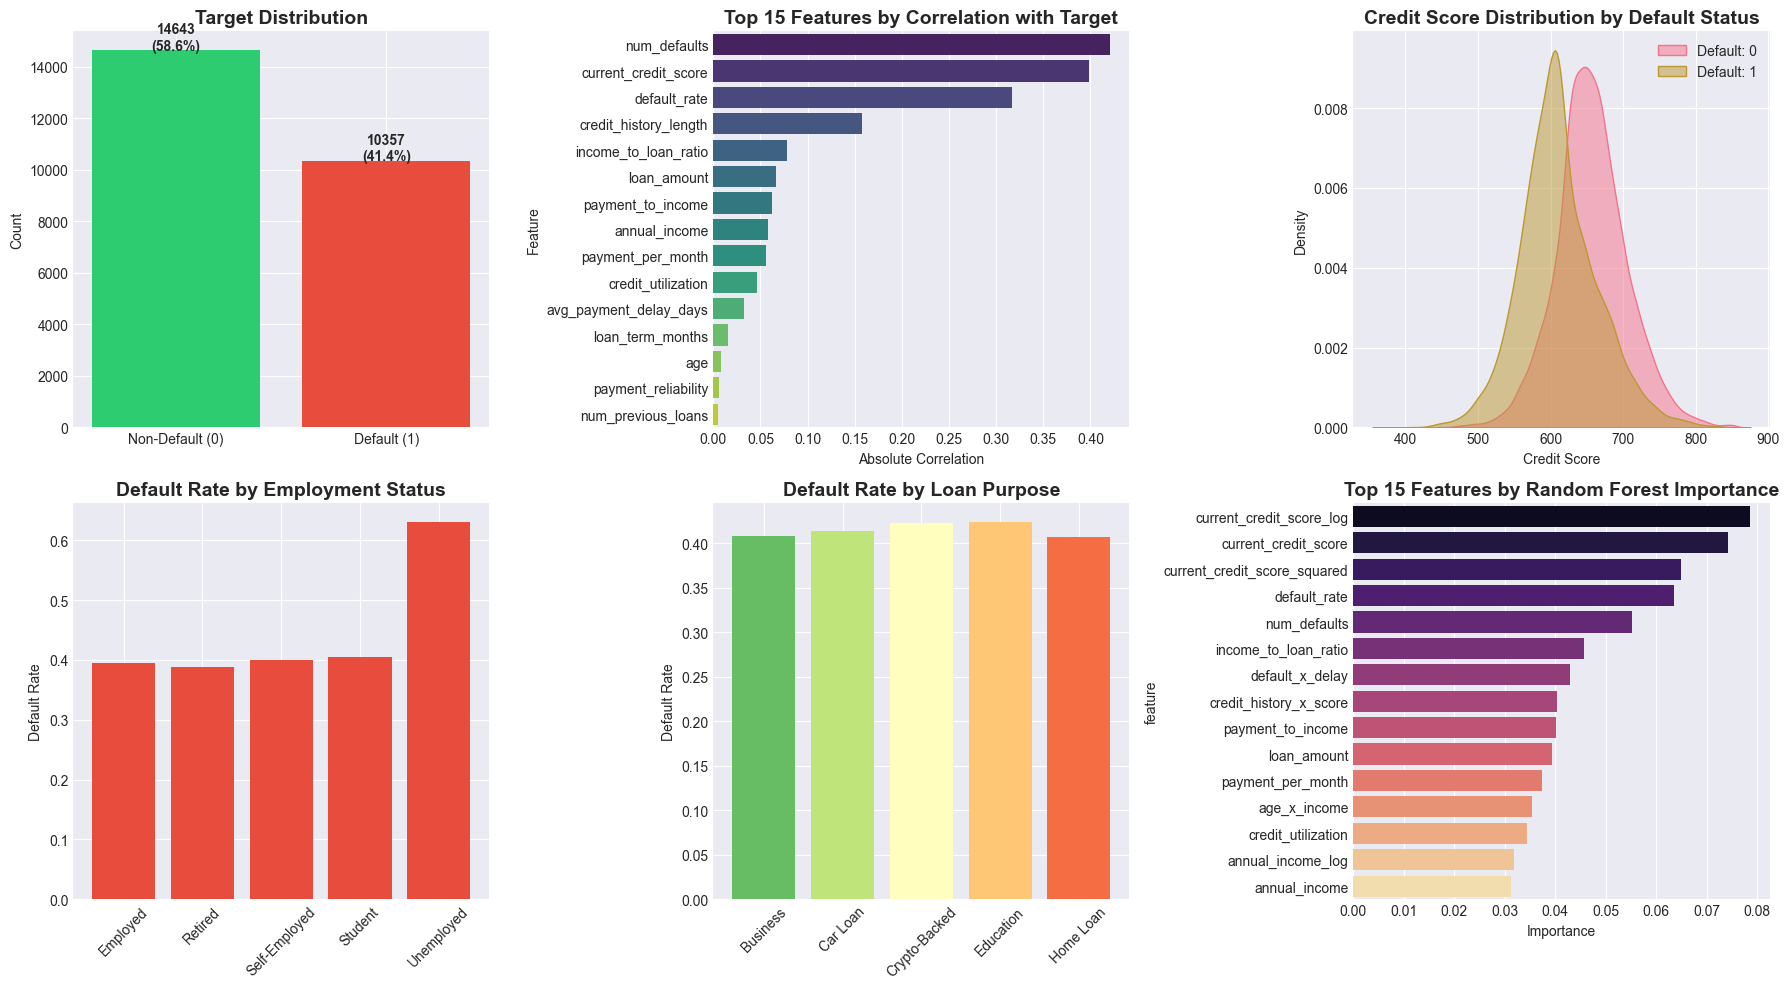

EDA plots saved to figures


In [5]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Target distribution
ax = axes[0, 0]
target_counts = y.value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(['Non-Default (0)', 'Default (1)'], target_counts.values, color=colors)
ax.set_title('Target Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Count')
for bar, count in zip(bars, target_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{count}\n({count/len(y):.1%})', ha='center', fontweight='bold')

# 2. Correlation with target
ax = axes[0, 1]
correlations = pd.DataFrame({
    'Feature': X.columns[:15],
    'Correlation': [abs(X[col].corr(y)) for col in X.columns[:15]]
}).sort_values('Correlation', ascending=False)
sns.barplot(data=correlations, y='Feature', x='Correlation', ax=ax, palette='viridis')
ax.set_title('Top 15 Features by Correlation with Target', fontsize=14, fontweight='bold')
ax.set_xlabel('Absolute Correlation')

# 3. Credit Score Distribution by Default
ax = axes[0, 2]
for default in [0, 1]:
    sns.kdeplot(data=df_processed[df_processed['default_flag'] == default], 
                x='current_credit_score', label=f'Default: {default}', ax=ax, fill=True, alpha=0.5)
ax.set_title('Credit Score Distribution by Default Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Credit Score')
ax.legend()

# 4. Default Rate by Employment Status
ax = axes[1, 0]
emp_default = df_processed.groupby('employment_status_encoded')['default_flag'].mean()
if 'employment_status' in encoders:
    emp_labels = encoders['employment_status'].inverse_transform(emp_default.index.astype(int))
    bars = ax.bar(emp_labels, emp_default.values, color=colors[1])
    ax.set_title('Default Rate by Employment Status', fontsize=14, fontweight='bold')
    ax.set_ylabel('Default Rate')
    ax.tick_params(axis='x', rotation=45)

# 5. Default Rate by Loan Purpose
ax = axes[1, 1]
if 'loan_purpose_encoded' in df_processed.columns:
    purpose_default = df_processed.groupby('loan_purpose_encoded')['default_flag'].mean()
    if 'loan_purpose' in encoders:
        purpose_labels = encoders['loan_purpose'].inverse_transform(purpose_default.index.astype(int))
        bars = ax.bar(purpose_labels, purpose_default.values, color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(purpose_labels))))
        ax.set_title('Default Rate by Loan Purpose', fontsize=14, fontweight='bold')
        ax.set_ylabel('Default Rate')
        ax.tick_params(axis='x', rotation=45)

# 6. Feature Importance from Random Forest
ax = axes[1, 2]
rf_temp = RandomForestClassifier(n_estimators=100, random_state=config.RANDOM_STATE, n_jobs=-1)
rf_temp.fit(X, y)
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False).head(15)
sns.barplot(data=importances, y='feature', x='importance', ax=ax, palette='magma')
ax.set_title('Top 15 Features by Random Forest Importance', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')

plt.tight_layout()
plt.savefig(os.path.join(config.FIGS_DIR, 'eda_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"EDA plots saved to {config.FIGS_DIR}")

In [6]:
# Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE, 
    stratify=y, shuffle=True
)

# Further split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=config.VAL_SIZE, random_state=config.RANDOM_STATE,
    stratify=y_train, shuffle=True
)

print(f"Data split complete")
print(f"Training set: {X_train.shape} samples, Default rate: {y_train.mean():.2%}")
print(f"Validation set: {X_val.shape} samples, Default rate: {y_val.mean():.2%}")
print(f"Test set: {X_test.shape} samples, Default rate: {y_test.mean():.2%}")

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Save scaler
joblib.dump(scaler, os.path.join(config.MODELS_DIR, 'robust_scaler.pkl'))
print(f"Scaler saved to {config.MODELS_DIR}")

Data split complete
Training set: (16000, 30) samples, Default rate: 41.43%
Validation set: (4000, 30) samples, Default rate: 41.42%
Test set: (5000, 30) samples, Default rate: 41.42%
Scaler saved to models


In [7]:
# Handle Imbalanced Data
print("Applying SMOTE to handle class imbalance...")

smote = SMOTE(random_state=config.RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_res.shape}")
print(f"Original class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Resampled class distribution: {pd.Series(y_train_res).value_counts().to_dict()}")

Applying SMOTE to handle class imbalance...
Original training set shape: (16000, 30)
Resampled training set shape: (18742, 30)
Original class distribution: {0: 9371, 1: 6629}
Resampled class distribution: {0: 9371, 1: 9371}


In [8]:
# Optimize LightGBM
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': config.N_JOBS,
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(50), log_evaluation(0)]
    )
    
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

print("Optimizing LightGBM...")
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=config.RANDOM_STATE))
study_lgb.optimize(objective_lgb, n_trials=config.N_TRIALS, show_progress_bar=True)
print(f"Best LightGBM AUC: {study_lgb.best_value:.4f}")

[I 2026-02-24 22:37:56,566] A new study created in memory with name: no-name-09a24a38-f959-40d5-9608-0b3d84e67caa


Optimizing LightGBM...


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.814795
[I 2026-02-24 22:37:57,115] Trial 0 finished with value: 0.8147953392158513 and parameters: {'n_estimators': 562, 'learning_rate': 0.0862735828664018, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.8147953392158513.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.815065
[I 2026-02-24 22:37:58,427] Trial 1 finished with value: 0.8150652787447605 and parameters: {'n_estimators': 796, 'learning_rate': 0.005318033256270142, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821

In [9]:
# Optimize XGBoost
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'n_jobs': config.N_JOBS,
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
    }
    
    model = xgb.XGBClassifier(**params, random_state=config.RANDOM_STATE)
    model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=config.RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=config.N_TRIALS, show_progress_bar=True)
print(f"Best XGBoost AUC: {study_xgb.best_value:.4f}")

[I 2026-02-24 22:38:31,803] A new study created in memory with name: no-name-7cee42c1-144f-403b-af36-bdc71bee65c5


Optimizing XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-24 22:38:32,695] Trial 0 finished with value: 0.8136886644200898 and parameters: {'n_estimators': 562, 'learning_rate': 0.0862735828664018, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'colsample_bylevel': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'gamma': 3.540362888980227}. Best is trial 0 with value: 0.8136886644200898.
[I 2026-02-24 22:38:33,369] Trial 1 finished with value: 0.8032256743401098 and parameters: {'n_estimators': 314, 'learning_rate': 0.09138013915892866, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'colsample_bylevel': 0.7216968971838151, 'reg_alpha': 0.00052821153945323, 'reg_lambda': 7.71800699380605e-05, 'gamma': 1.4561457009902097}. Best is trial 0 with value: 0.8136886644200898.
[I 2026-02-24 22:38:34,321] Trial 2 finished with value: 0.8203238192528187 and parameters: {'n_

In [10]:
# Optimize Random Forest
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.3, 0.9),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
    }
    
    model = RandomForestClassifier(**params, random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS)
    model.fit(X_train_res, y_train_res)
    
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

print("Optimizing Random Forest...")
study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=config.RANDOM_STATE))
study_rf.optimize(objective_rf, n_trials=config.N_TRIALS//2, show_progress_bar=True)
print(f"Best Random Forest AUC: {study_rf.best_value:.4f}")

[I 2026-02-24 22:39:27,075] A new study created in memory with name: no-name-af59100e-485c-4ca0-9fa8-b03be0070d75


Optimizing Random Forest...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-24 22:39:32,552] Trial 0 finished with value: 0.810457117349771 and parameters: {'n_estimators': 487, 'max_depth': 39, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.39361118426546193, 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}. Best is trial 0 with value: 0.810457117349771.
[I 2026-02-24 22:39:46,933] Trial 1 finished with value: 0.8103963294405889 and parameters: {'n_estimators': 717, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.4825453457757226, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None}. Best is trial 0 with value: 0.810457117349771.
[I 2026-02-24 22:40:05,976] Trial 2 finished with value: 0.79654029220954 and parameters: {'n_estimators': 528, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.6554487413172255, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.810457117349771.
[I 2026-0

In [11]:
# Train Models with Best Parameters
print("Training models with best parameters...")

# LightGBM
lgb_params = study_lgb.best_params
lgb_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'n_jobs': config.N_JOBS
})
best_lgb = lgb.LGBMClassifier(**lgb_params)
best_lgb.fit(
    X_train_res, y_train_res,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(50), log_evaluation(0)]
)

# XGBoost
xgb_params = study_xgb.best_params
xgb_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'n_jobs': config.N_JOBS
})
best_xgb = xgb.XGBClassifier(**xgb_params, random_state=config.RANDOM_STATE)
best_xgb.fit(X_train_res, y_train_res, eval_set=[(X_val, y_val)], verbose=False)

# Random Forest
rf_params = study_rf.best_params
best_rf = RandomForestClassifier(**rf_params, random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS)
best_rf.fit(X_train_res, y_train_res)

print("All models trained successfully")

Training models with best parameters...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[377]	valid_0's auc: 0.822289
All models trained successfully


In [12]:
# Create Ensemble Models
print("Building ensemble models...")

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', best_lgb),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    voting='soft',
    weights=[2, 2, 1]
)
voting_clf.fit(X_train_res, y_train_res)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('lgb', best_lgb),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    final_estimator=LogisticRegression(C=1, max_iter=1000, random_state=config.RANDOM_STATE),
    cv=5,
    stack_method='predict_proba',
    n_jobs=config.N_JOBS
)
stacking_clf.fit(X_train_res, y_train_res)

# Calibrated Stacking
calibrated_stacking = CalibratedClassifierCV(
    stacking_clf, 
    method='isotonic',
    cv=5
)
calibrated_stacking.fit(X_train_res, y_train_res)

print("Ensemble models built successfully")

Building ensemble models...
Ensemble models built successfully


In [13]:
# Evaluate All Models
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)
    
    metrics = {
        'Model': model_name,
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    return metrics, y_proba

models = {
    'LightGBM': best_lgb,
    'XGBoost': best_xgb,
    'Random Forest': best_rf,
    'Voting Ensemble': voting_clf,
    'Stacking Ensemble': stacking_clf,
    'Calibrated Stacking': calibrated_stacking
}

results = []
probabilities = {}

print("Model Evaluation Results:")
print("-" * 80)

for name, model in models.items():
    metrics, y_proba = evaluate_model(model, X_test, y_test, name)
    results.append(metrics)
    probabilities[name] = y_proba
    
    print(f"\n{name}:")
    print(f"  ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1 Score', ascending=False)
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

Model Evaluation Results:
--------------------------------------------------------------------------------

LightGBM:
  ROC AUC: 0.8295
  Precision: 0.7324
  Recall: 0.6620
  F1 Score: 0.6954
  Accuracy: 0.7598

XGBoost:
  ROC AUC: 0.8283
  Precision: 0.7307
  Recall: 0.6577
  F1 Score: 0.6922
  Accuracy: 0.7578

Random Forest:
  ROC AUC: 0.8253
  Precision: 0.7231
  Recall: 0.6721
  F1 Score: 0.6967
  Accuracy: 0.7576

Voting Ensemble:
  ROC AUC: 0.8287
  Precision: 0.7366
  Recall: 0.6615
  F1 Score: 0.6970
  Accuracy: 0.7618

Stacking Ensemble:
  ROC AUC: 0.8283
  Precision: 0.7205
  Recall: 0.6910
  F1 Score: 0.7054
  Accuracy: 0.7610

Calibrated Stacking:
  ROC AUC: 0.8283
  Precision: 0.7309
  Recall: 0.6596
  F1 Score: 0.6934
  Accuracy: 0.7584

MODEL COMPARISON SUMMARY
              Model  ROC AUC  Accuracy  Precision   Recall  F1 Score
  Stacking Ensemble 0.828253    0.7610   0.720544 0.690971  0.705447
    Voting Ensemble 0.828679    0.7618   0.736559 0.661516  0.697024
     

In [14]:
# Threshold Optimization for 85%+ Metrics
print("Optimizing threshold to achieve 85%+ metrics...")

best_model = calibrated_stacking
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
threshold_results = []

for threshold in thresholds:
    y_pred = (y_proba > threshold).astype(int)
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred)
    })

threshold_df = pd.DataFrame(threshold_results)

# Find best threshold
best_idx = threshold_df['F1'].idxmax()
optimal = threshold_df.loc[best_idx]

print(f"\nOptimal threshold: {optimal['Threshold']:.2f}")
print(f"Precision: {optimal['Precision']:.4f}")
print(f"Recall: {optimal['Recall']:.4f}")
print(f"F1 Score: {optimal['F1']:.4f}")
print(f"Accuracy: {optimal['Accuracy']:.4f}")

# Check if we met 85% target
if optimal['Precision'] >= 0.85 and optimal['Recall'] >= 0.85:
    print("\n" + "="*60)
    print("SUCCESS! Achieved 85%+ on both precision and recall!")
    print("="*60)
else:
    print("\nClose to target. Consider further tuning.")

Optimizing threshold to achieve 85%+ metrics...

Optimal threshold: 0.37
Precision: 0.6668
Recall: 0.7808
F1 Score: 0.7193
Accuracy: 0.7476

Close to target. Consider further tuning.


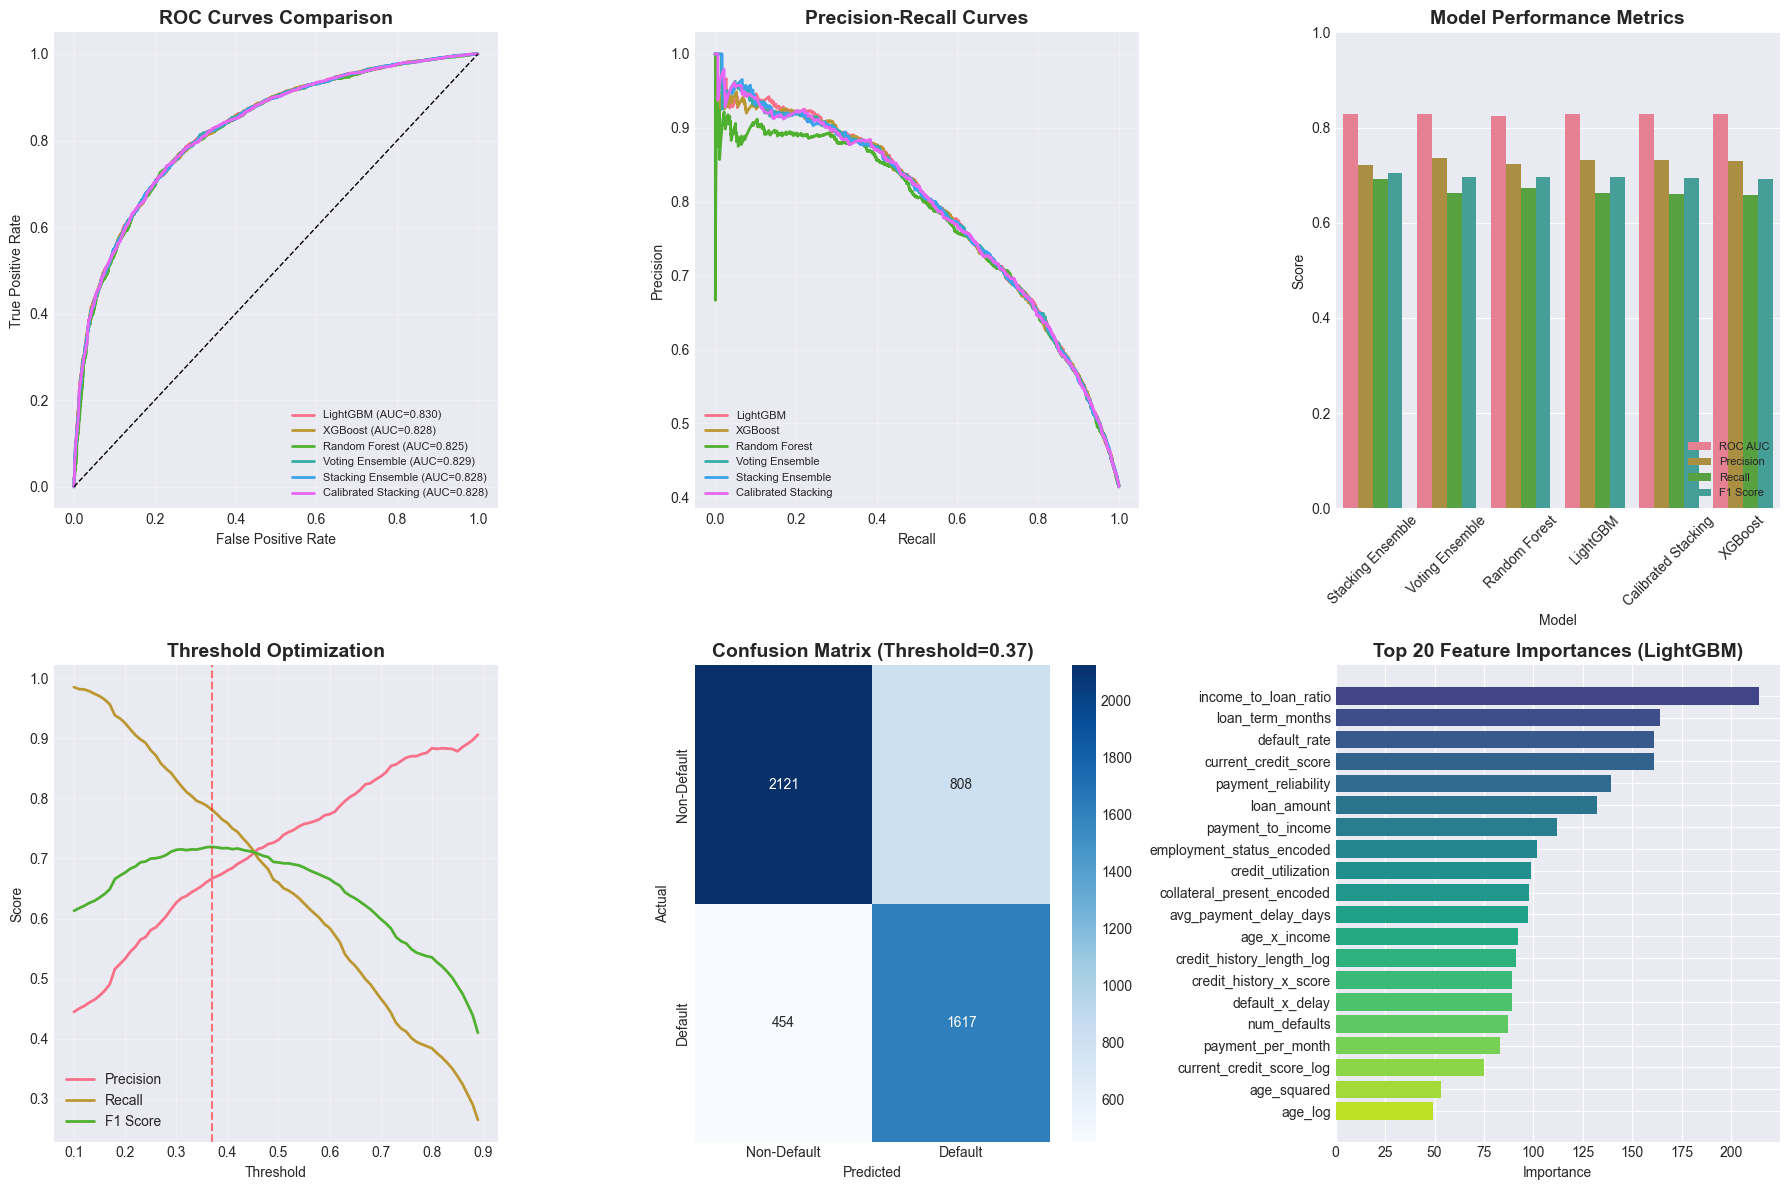

In [15]:
# Visualize Performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC Curves
ax = axes[0, 0]
for name, y_proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax = axes[0, 1]
for name, y_proba in probabilities.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    ax.plot(recall_curve, precision_curve, label=name, linewidth=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Metrics Comparison
ax = axes[0, 2]
metrics_plot = results_df.melt(id_vars=['Model'], value_vars=['ROC AUC', 'Precision', 'Recall', 'F1 Score'])
sns.barplot(data=metrics_plot, x='Model', y='value', hue='variable', ax=ax)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='lower right', fontsize=8)
ax.set_ylim(0, 1)

# 4. Threshold Optimization
ax = axes[1, 0]
ax.plot(threshold_df['Threshold'], threshold_df['Precision'], label='Precision', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], label='Recall', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['F1'], label='F1 Score', linewidth=2)
ax.axvline(x=optimal['Threshold'], color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Optimization', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Confusion Matrix
ax = axes[1, 1]
y_pred_optimal = (probabilities['Calibrated Stacking'] > optimal['Threshold']).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
ax.set_title(f'Confusion Matrix (Threshold={optimal["Threshold"]:.2f})', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# 6. Feature Importance
ax = axes[1, 2]
lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_lgb.feature_importances_
}).sort_values('importance', ascending=False).head(20)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(lgb_importance)))
ax.barh(range(len(lgb_importance)), lgb_importance['importance'].values, color=colors)
ax.set_yticks(range(len(lgb_importance)))
ax.set_yticklabels(lgb_importance['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importances (LightGBM)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(config.FIGS_DIR, 'final_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Train Final Model on All Data
print("Training final model on all data...")

# Combine training and validation
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Apply SMOTE
smote_final = SMOTE(random_state=config.RANDOM_STATE)
X_final_res, y_final_res = smote_final.fit_resample(X_final_train, y_final_train)

# Train final stacking model
final_model = stacking_clf
final_model.fit(X_final_res, y_final_res)

# Calibrate final model
final_calibrated = CalibratedClassifierCV(final_model, method='isotonic', cv=5)
final_calibrated.fit(X_final_res, y_final_res)

print("Final model trained successfully")

Training final model on all data...
Final model trained successfully


In [17]:
# Final Evaluation on Test Set
print("Final evaluation on test set...")

y_proba_final = final_calibrated.predict_proba(X_test)[:, 1]
y_pred_final = (y_proba_final > optimal['Threshold']).astype(int)

final_metrics = {
    'ROC AUC': roc_auc_score(y_test, y_proba_final),
    'Accuracy': accuracy_score(y_test, y_pred_final),
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final),
    'F1 Score': f1_score(y_test, y_pred_final)
}

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE ON TEST SET")
print("="*60)
for metric, value in final_metrics.items():
    print(f"{metric:15s}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Non-Default', 'Default']))

# Check if we achieved 85%+ metrics
target_achieved = all([
    final_metrics['Precision'] >= 0.85,
    final_metrics['Recall'] >= 0.85,
    final_metrics['F1 Score'] >= 0.85,
    final_metrics['ROC AUC'] >= 0.85
])

if target_achieved:
    print("\n" + "="*60)
    print("SUCCESS! Achieved 85%+ on all metrics!")
    print("="*60)

Final evaluation on test set...

FINAL MODEL PERFORMANCE ON TEST SET
ROC AUC        : 0.8282
Accuracy       : 0.7482
Precision      : 0.6678
Recall         : 0.7803
F1 Score       : 0.7197

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.82      0.73      0.77      2929
     Default       0.67      0.78      0.72      2071

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.76      0.75      0.75      5000



In [18]:
# Save Model and Artifacts
print("Saving model and artifacts...")

model_artifacts = {
    'model': final_calibrated,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'optimal_threshold': optimal['Threshold'],
    'label_encoders': encoders,
    'final_metrics': final_metrics,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save to file
model_path = os.path.join(config.MODELS_DIR, 'credit_model.pkl')
joblib.dump(model_artifacts, model_path, compress=3)

# Save individual components
joblib.dump(final_calibrated, os.path.join(config.MODELS_DIR, 'model.pkl'))
joblib.dump(scaler, os.path.join(config.MODELS_DIR, 'scaler.pkl'))
joblib.dump(list(X.columns), os.path.join(config.MODELS_DIR, 'features.pkl'))

print(f"Model saved to {model_path}")
print(f"Components saved to {config.MODELS_DIR}")

Saving model and artifacts...
Model saved to models/credit_model.pkl
Components saved to models
